In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the Parquet file
df = pd.read_parquet("Store_Sales_Price_Elasticity_Promotions_Data.parquet")

In [3]:
print("Shape:", df.shape)
print(df.dtypes)
print(df.head())

Shape: (697894, 7)
Store_Number            int16
SKU_Coded               int32
Product_Class_Code      int16
Sold_Date              object
Qty_Sold                int16
Total_Sale_Value      float32
On_Promo                 int8
dtype: object
   Store_Number  SKU_Coded  Product_Class_Code   Sold_Date  Qty_Sold  \
0          1320    6172800               22875  2021-11-02         3   
1          2310    6172800               22875  2021-11-03         1   
2          3080    6172800               22875  2021-11-03         1   
3          2310    6172800               22875  2021-11-06         1   
4          4840    6172800               22875  2021-11-07         1   

   Total_Sale_Value  On_Promo  
0         56.849998         0  
1         18.950001         0  
2         18.950001         0  
3         18.950001         0  
4         18.950001         0  


In [4]:
# Convert date
df['Sold_Date'] = pd.to_datetime(df['Sold_Date'])

In [5]:
# Create unit price
df['Unit_Price'] = df['Total_Sale_Value'] / df['Qty_Sold']

In [6]:
# Check Qty_Sold <= 0
qty_issues = df[df['Qty_Sold'] <= 0]
print("Rows with Qty_Sold <= 0:", len(qty_issues))

# Check Unit_Price <= 0
df['Unit_Price'] = df['Total_Sale_Value'] / df['Qty_Sold']
price_issues = df[df['Unit_Price'] <= 0]
print("Rows with Unit_Price <= 0:", len(price_issues))


Rows with Qty_Sold <= 0: 0
Rows with Unit_Price <= 0: 0


In [7]:
print(df[['Sold_Date', 'Qty_Sold', 'Unit_Price', 'On_Promo']].head())

   Sold_Date  Qty_Sold  Unit_Price  On_Promo
0 2021-11-02         3   18.949999         0
1 2021-11-03         1   18.950001         0
2 2021-11-03         1   18.950001         0
3 2021-11-06         1   18.950001         0
4 2021-11-07         1   18.950001         0


In [8]:
# Check unique values
print("Unique values in On_Promo:", df['On_Promo'].unique())

# Value counts for each
print("\nCounts of each value:")
print(df['On_Promo'].value_counts())


Unique values in On_Promo: [0 1]

Counts of each value:
On_Promo
0    693528
1      4366
Name: count, dtype: int64


In [9]:

# STEP 1: Find top 5 SKUs by total quantity sold
top_5_skus = df.groupby("SKU_Coded")["Qty_Sold"].sum().sort_values(ascending=False).head(5).index.tolist()
print(top_5_skus)

[6200700, 6194250, 6193800, 6177750, 6177350]


In [10]:
from prophet import Prophet


 Forecasting for SKU: 6200700


02:25:59 - cmdstanpy - INFO - Chain [1] start processing
02:26:01 - cmdstanpy - INFO - Chain [1] done processing


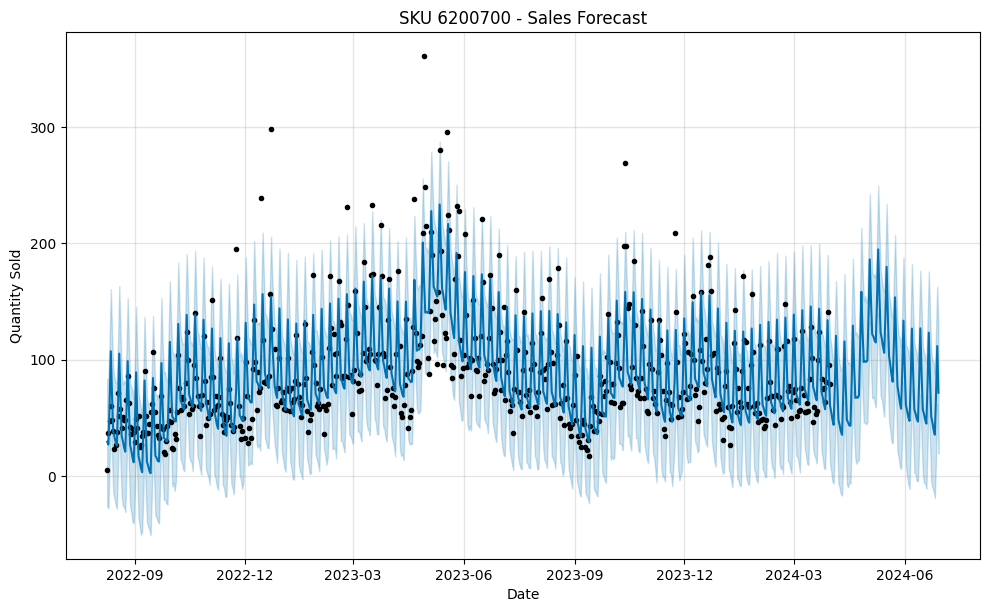


 Forecasting for SKU: 6194250


02:26:02 - cmdstanpy - INFO - Chain [1] start processing
02:26:02 - cmdstanpy - INFO - Chain [1] done processing


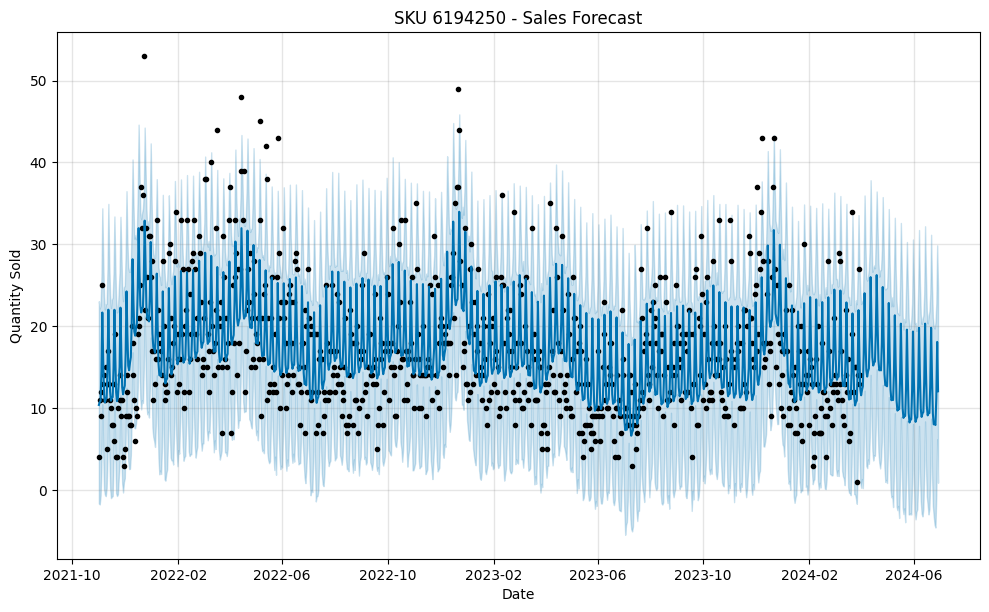


 Forecasting for SKU: 6193800


02:26:03 - cmdstanpy - INFO - Chain [1] start processing
02:26:03 - cmdstanpy - INFO - Chain [1] done processing


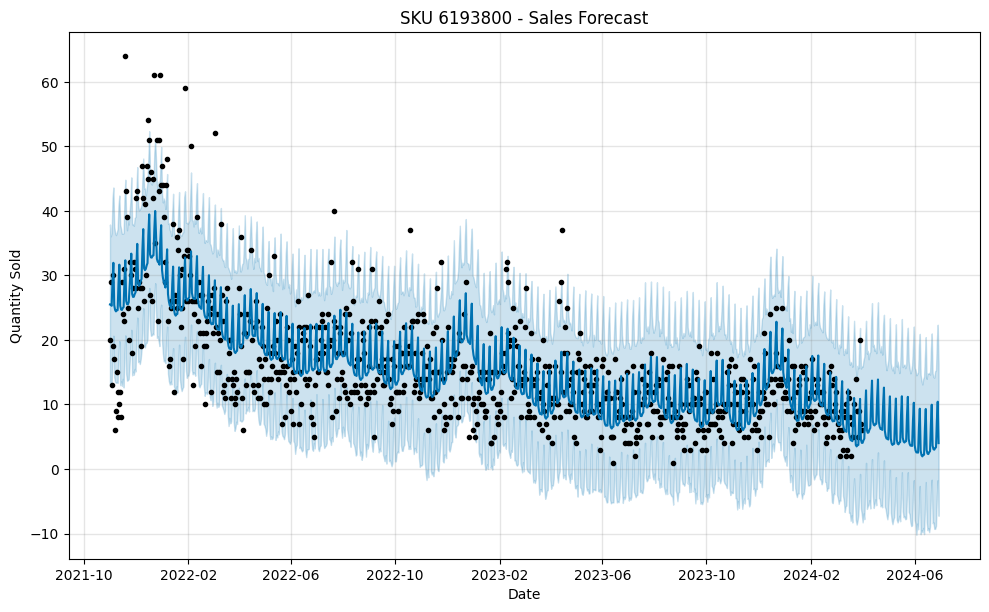


 Forecasting for SKU: 6177750


02:26:04 - cmdstanpy - INFO - Chain [1] start processing
02:26:05 - cmdstanpy - INFO - Chain [1] done processing


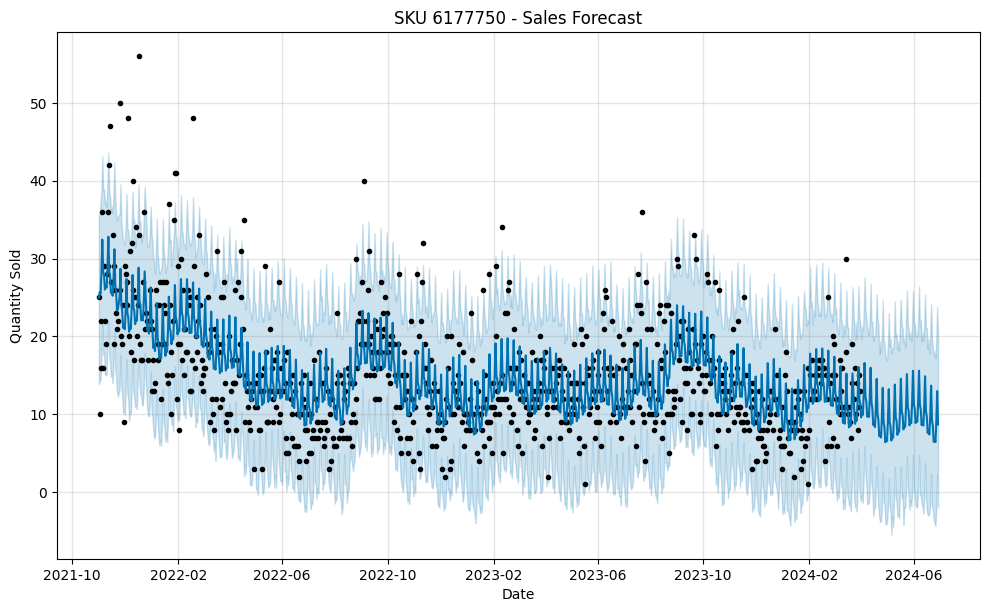


 Forecasting for SKU: 6177350


02:26:06 - cmdstanpy - INFO - Chain [1] start processing
02:26:06 - cmdstanpy - INFO - Chain [1] done processing


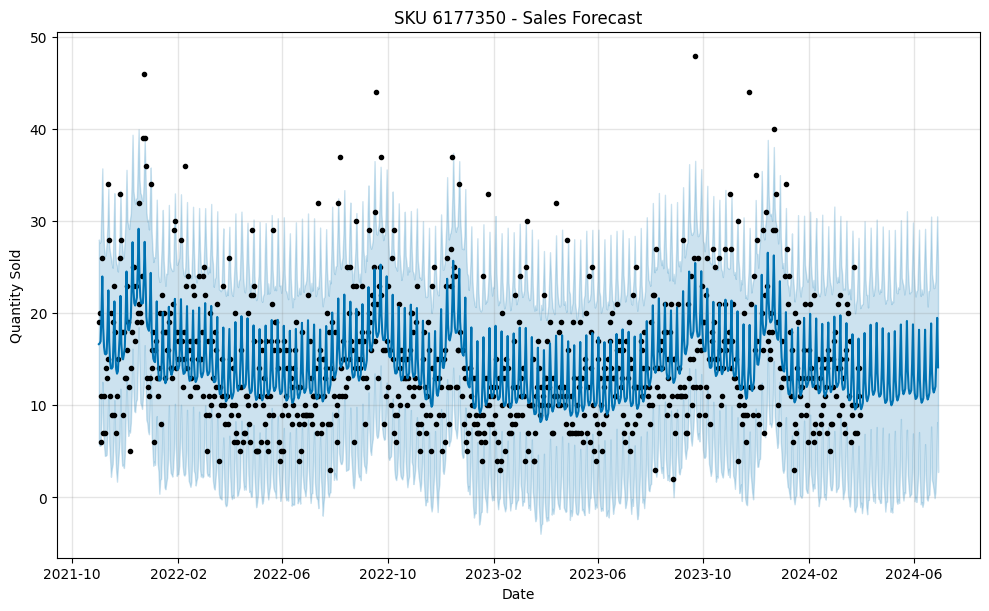

In [11]:

# Prepare final storage
forecast_all = []
for sku in top_5_skus:
    print(f"\n Forecasting for SKU: {sku}")
    
    sku_df = df[df['SKU_Coded'] == sku]
    
    sku_daily = sku_df.groupby("Sold_Date")["Qty_Sold"].sum().reset_index()
    
    sku_daily.columns = ['ds', 'y']
    sku_daily['ds'] = pd.to_datetime(sku_daily['ds'])

    model = Prophet(interval_width=0.95, yearly_seasonality=True)
    model.fit(sku_daily)

    # Future dataframe (e.g. 90 days ahead)
    future = model.make_future_dataframe(periods=90)
    forecast = model.predict(future)
        
    future_forecast = forecast[forecast['ds'] > sku_daily['ds'].max()][['ds', 'yhat']]
    future_forecast['SKU_Coded'] = sku

    forecast_all.append(future_forecast)
    forecast_df = pd.concat(forecast_all)
    

    # Plot
    fig = model.plot(forecast)
    plt.title(f"SKU {sku} - Sales Forecast")
    plt.xlabel("Date")
    plt.ylabel("Quantity Sold")
    plt.show()


In [12]:
import statsmodels.api as sm

In [13]:
# Log-transform
df['log_qty'] = np.log(df['Qty_Sold'])
df['log_price'] = np.log(df['Unit_Price'])

# Regression
X = sm.add_constant(df['log_price'])
model = sm.OLS(df['log_qty'], X).fit()
print(model.summary())

price_elasticity = model.params['log_price']
print(f"Estimated Price Elasticity: {price_elasticity}")

                            OLS Regression Results                            
Dep. Variable:                log_qty   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                 2.138e+04
Date:                Thu, 14 Aug 2025   Prob (F-statistic):               0.00
Time:                        02:26:13   Log-Likelihood:            -4.3925e+05
No. Observations:              697894   AIC:                         8.785e+05
Df Residuals:                  697892   BIC:                         8.785e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4092      0.001    295.167      0.0

In [ ]:


df['promo_dummy'] = df['On_Promo'].astype(int)

X = df[['log_price', 'promo_dummy']]
X = sm.add_constant(X) 
y = df['log_qty']

model = sm.OLS(y, X).fit()

print(model.summary())

price_elasticity = model.params['log_price']
promo_effect = model.params['promo_dummy']
print(f"Estimated Price Elasticity: {price_elasticity}")
print(f"Promotion Effect (log scale): {promo_effect}")


                            OLS Regression Results                            
Dep. Variable:                log_qty   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                 1.729e+04
Date:                Thu, 14 Aug 2025   Prob (F-statistic):               0.00
Time:                        02:26:17   Log-Likelihood:            -4.3290e+05
No. Observations:              697894   AIC:                         8.658e+05
Df Residuals:                  697891   BIC:                         8.658e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4098      0.001    298.273      

In [ ]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X = sku_features[['Unit_Price', 'Qty_Sold', 'On_Promo']]

sil_scores = []
K = range(2, 10)  # try 2 to 9 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

plt.plot(K, sil_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score to Find Optimal Clusters')
plt.show()


In [31]:
from sklearn.cluster import KMeans

# Example features: average price, avg sales, promo frequency per SKU
sku_features = df.groupby('SKU_Coded').agg({
    'Unit_Price': 'mean',
    'Qty_Sold': 'mean',
    'On_Promo': 'mean'
}).reset_index()

kmeans = KMeans(n_clusters=4, random_state=42)
sku_features['cluster'] = kmeans.fit_predict(sku_features[['Unit_Price', 'Qty_Sold', 'On_Promo']])


In [32]:
print(sku_features['cluster'].value_counts())


cluster
1    393
3    176
0     75
2     15
Name: count, dtype: int64


In [33]:
cluster_summary = sku_features.groupby('cluster')[['Unit_Price', 'Qty_Sold', 'On_Promo']].mean()
print(cluster_summary)


         Unit_Price  Qty_Sold  On_Promo
cluster                                
0         43.607807  1.124179  0.012004
1          5.531864  1.651646  0.001244
2         87.616089  1.084930  0.013079
3         21.136778  1.257834  0.006245


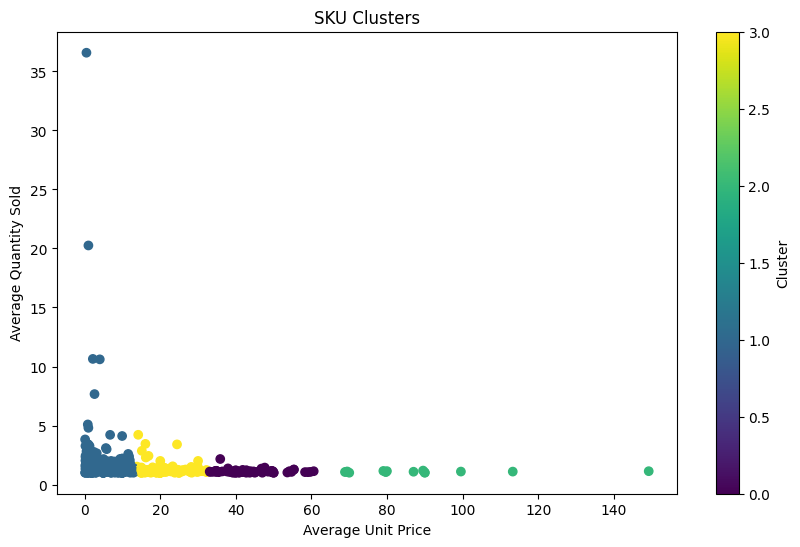

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
scatter = plt.scatter(sku_features['Unit_Price'], sku_features['Qty_Sold'], c=sku_features['cluster'], cmap='viridis')
plt.xlabel('Average Unit Price')
plt.ylabel('Average Quantity Sold')
plt.title('SKU Clusters')
plt.colorbar(scatter, label='Cluster')
plt.show()


In [35]:
for c in sku_features['cluster'].unique():
    cluster_skus = sku_features[sku_features['cluster'] == c]['SKU_Coded']
    cluster_data = df[df['SKU_Coded'].isin(cluster_skus)].copy()
    
    # No need to filter positive Qty_Sold or Unit_Price because data is already positive
    
    # Create log columns
    cluster_data['log_qty'] = np.log(cluster_data['Qty_Sold'])
    cluster_data['log_price'] = np.log(cluster_data['Unit_Price'])
    cluster_data['promo_dummy'] = cluster_data['On_Promo'].astype(int)
    
    X = cluster_data[['log_price', 'promo_dummy']]
    X = sm.add_constant(X)
    y = cluster_data['log_qty']
    
    model = sm.OLS(y, X).fit()
    
    print(f"\nCluster {c} Elasticity and Promo Effect:")
    print(model.summary())
    print(f"Price Elasticity: {model.params['log_price']}")
    print(f"Promotion Effect: {model.params['promo_dummy']}")




Cluster 3 Elasticity and Promo Effect:
                            OLS Regression Results                            
Dep. Variable:                log_qty   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     4335.
Date:                Thu, 14 Aug 2025   Prob (F-statistic):               0.00
Time:                        02:29:38   Log-Likelihood:                -74802.
No. Observations:              183854   AIC:                         1.496e+05
Df Residuals:                  183851   BIC:                         1.496e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const     

In [ ]:
# Merge sales data with SKU features
df_merged = df.merge(
    sku_features[['SKU_Coded', 'cluster', 'price_elasticity', 'promo_effect']],
    on='SKU_Coded',
    how='left'
)

df_export = df_merged[['SKU_Coded', 'Sold_Date', 'Qty_Sold', 'Unit_Price', 'On_Promo',
                       'cluster', 'price_elasticity', 'promo_effect',
                       'Product_Class_Code', 'Total_Sale_Value']]

df_export.to_csv('final_sales_with_clusters_and_products.csv', index=False)

print("✅ File saved: final_sales_with_clusters_and_products.csv")
